[View in Colaboratory](https://colab.research.google.com/github/animeshseemendra/MNIST-Database/blob/master/MNIST_database.ipynb)

In [0]:
from keras.datasets import mnist
(X_train,y_train),(X_test,y_test)=mnist.load_data()


In [4]:
print("Number of training datasets : %d"% len(X_train))
print("Number of testing datasets : %d"% len(X_test))

Number of training datasets : 60000
Number of testing datasets : 10000


In [5]:
print(X_train.shape)

(60000, 28, 28)


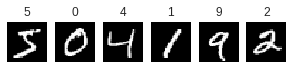

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import numpy as np

# plot first six training images
fig = plt.figure(figsize=(5,5))
for i in range(6):
    ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(str(y_train[i]))

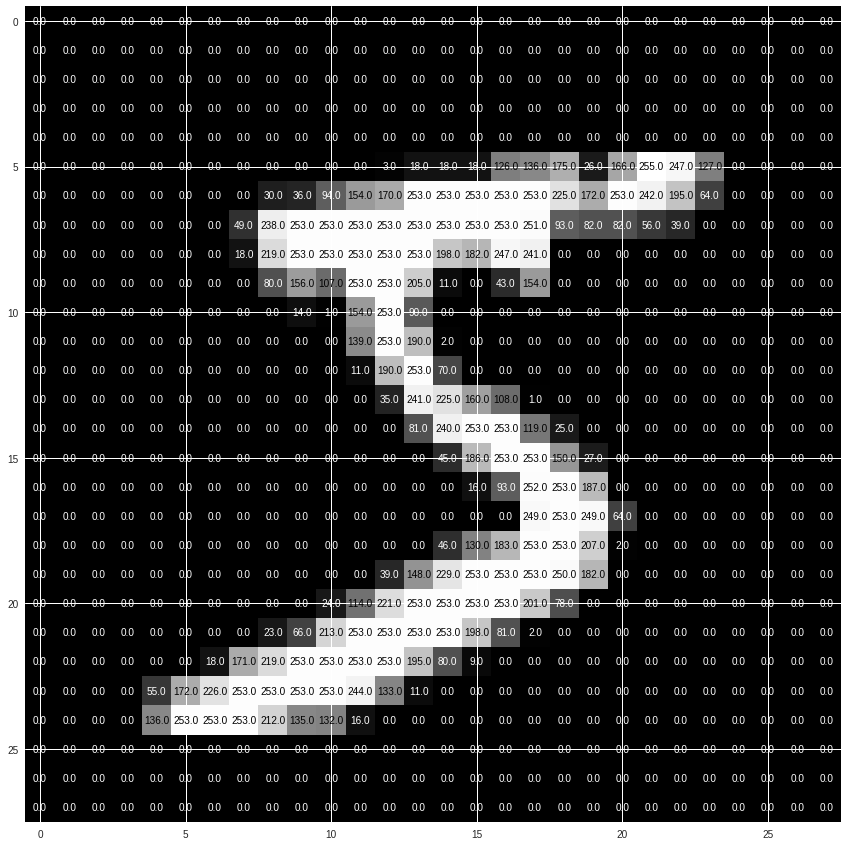

In [7]:
def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

fig = plt.figure(figsize = (15,15)) 
ax = fig.add_subplot(111)
visualize_input(X_train[0], ax)



In [0]:
X_train=X_train.astype('float32')/255
X_test=X_test.astype('float32')/255

In [9]:
from keras.utils.np_utils import to_categorical as tc
print(y_train[:10]) #integer form
y_train=tc(y_train,10)
y_test=tc(y_test,10)
print(y_train[:10]) #categorical form

[5 0 4 1 9 2 1 3 1 4]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [48]:
#MODEL ARCHITECTURE
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
#model
model=Sequential()
model.add(Flatten(input_shape=X_train.shape[1:]))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])

In [50]:
from keras.callbacks import ModelCheckpoint   

# train the model
checkpointer = ModelCheckpoint(filepath='mnist.model.best.hdf5', 
                               verbose=1, save_best_only=True)
hist = model.fit(X_train, y_train, batch_size=128, epochs=10,
          validation_split=0.2, callbacks=[checkpointer],
          verbose=1, shuffle=True)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 9s 191us/step - loss: 0.2752 - acc: 0.9153 - val_loss: 0.1157 - val_acc: 0.9652

Epoch 00001: val_loss improved from inf to 0.11573, saving model to mnist.model.best.hdf5
Epoch 2/10
48000/48000 [==============================] - 9s 189us/step - loss: 0.1099 - acc: 0.9657 - val_loss: 0.1028 - val_acc: 0.9697

Epoch 00002: val_loss improved from 0.11573 to 0.10279, saving model to mnist.model.best.hdf5
Epoch 3/10
17408/48000 [=========>....................] - ETA: 5s - loss: 0.0814 - acc: 0.9750

48000/48000 [==============================] - 9s 186us/step - loss: 0.0805 - acc: 0.9757 - val_loss: 0.0809 - val_acc: 0.9772

Epoch 00003: val_loss improved from 0.10279 to 0.08092, saving model to mnist.model.best.hdf5
Epoch 4/10
48000/48000 [==============================] - 9s 186us/step - loss: 0.0617 - acc: 0.9811 - val_loss: 0.0989 - val_acc: 0.9739

Epoch 00004: val_loss did not improve from 0.08092
Epoch 5/10
34816/48000 [====================>.........] - ETA: 2s - loss: 0.0510 - acc: 0.9841

48000/48000 [==============================] - 9s 184us/step - loss: 0.0513 - acc: 0.9845 - val_loss: 0.0888 - val_acc: 0.9777

Epoch 00005: val_loss did not improve from 0.08092
Epoch 6/10
48000/48000 [==============================] - 9s 183us/step - loss: 0.0449 - acc: 0.9857 - val_loss: 0.0895 - val_acc: 0.9796

Epoch 00006: val_loss did not improve from 0.08092
Epoch 7/10
46336/48000 [===========================>..] - ETA: 0s - loss: 0.0380 - acc: 0.9884

48000/48000 [==============================] - 9s 184us/step - loss: 0.0382 - acc: 0.9883 - val_loss: 0.0911 - val_acc: 0.9800

Epoch 00007: val_loss did not improve from 0.08092
Epoch 8/10
48000/48000 [==============================] - 9s 186us/step - loss: 0.0327 - acc: 0.9902 - val_loss: 0.0999 - val_acc: 0.9792

Epoch 00008: val_loss did not improve from 0.08092
Epoch 9/10
46976/48000 [============================>.] - ETA: 0s - loss: 0.0299 - acc: 0.9907

48000/48000 [==============================] - 9s 185us/step - loss: 0.0296 - acc: 0.9908 - val_loss: 0.0980 - val_acc: 0.9793

Epoch 00009: val_loss did not improve from 0.08092
Epoch 10/10
48000/48000 [==============================] - 9s 185us/step - loss: 0.0284 - acc: 0.9918 - val_loss: 0.0989 - val_acc: 0.9809

Epoch 00010: val_loss did not improve from 0.08092


In [0]:
model.load_weights('mnist.model.best.hdf5')


In [52]:
# evaluate test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 97.6100%
